In [12]:
import warnings

warnings.filterwarnings("ignore")

import torch
import anndata as ad
import harmonypy as hm
import pandas as pd
import numpy as np
import scanpy as sc
import os
import yaml
import time
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.decomposition import PCA
from iSp3D import Func
from iSp3D import Metrics
from iSp3D import iSpaNet
from iSp3D.Classifier import iSpaNetClassifier
from iSp3D.Utils import align_spatial_slices
from iSp3D.Attribution import compute_and_summary_by_cluster

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['R_HOME'] = r'C:\Program Files\R\R-4.4.2'
os.environ['R_USER'] = r'C:\Users\CLEARLOVE\.conda\envs\STG\Lib\site-packages\rpy2'


def mapping2int(string_array):
    mapping = {}
    result = []
    for string in string_array:
        if string not in mapping:
            mapping[string] = len(mapping)
        result.append(mapping[string])
    return result, mapping


def inverse_pca_transform(pca, recon_pca_data, adata):
    recon_scaled = pca.inverse_transform(recon_pca_data)
    recon_log1p = recon_scaled * adata.var['std'].values + adata.var['mean'].values
    recon_normalized = np.exp(recon_log1p) - 1 
    return recon_normalized


def compute_fscoreLISI(Tmp_adata, LT_key, BT_key, PD_key):
    LISI_batch_norm = hm.compute_lisi(Tmp_adata.obsm[LT_key], Tmp_adata.obs[[BT_key]], label_colnames=[BT_key])[:, 0]
    LISI_domain_norm = hm.compute_lisi(Tmp_adata.obsm[LT_key], Tmp_adata.obs[[PD_key]], label_colnames=[PD_key])[:, 0]

    LISI = 2 * (1 / LISI_domain_norm) * LISI_batch_norm / (1 / LISI_domain_norm + LISI_batch_norm)
    return LISI


def get_data(proj_list, config):
    global graph_dict
    result, mapping = mapping2int(proj_list)
    for proj_name in tqdm(proj_list):
        adata_tmp = sc.read_h5ad(os.path.join(r"C:\Code\Data\Axolotl Brain\\" + proj_name + ".h5ad"))
        adata_tmp.var_names_make_unique()

        adata_tmp.obs['batch_name'] = proj_name
        adata_tmp.obs['slice_id'] = mapping[proj_name]

        graph_dict_tmp = Func.graph_construction(adata_tmp, config['k_cutoff'])
        if proj_name == proj_list[0]:
            adata = adata_tmp
            graph_dict = graph_dict_tmp
            name = proj_name
            adata.obs['proj_name'] = proj_name
        else:
            var_names = adata.var_names.intersection(adata_tmp.var_names)
            adata = adata[:, var_names]
            adata_tmp = adata_tmp[:, var_names]
            adata_tmp.obs['proj_name'] = proj_name

            adata = adata.concatenate(adata_tmp)
            graph_dict = Func.combine_graph_dict(graph_dict, graph_dict_tmp)
            name = name + '_' + proj_name

    adata.layers['count'] = adata.X.toarray()
    sc.pp.filter_genes(adata, min_cells=50)
    sc.pp.filter_genes(adata, min_counts=10)
    sc.pp.normalize_total(adata, target_sum=1e6)
    sc.pp.log1p(adata)

    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=config['top_genes'])
    adata = adata[:, adata.var['highly_variable'] == True]
    sc.pp.scale(adata)

    adata.obsm['X_original'] = adata.X.copy()

    pca = PCA(n_components=200, random_state=42)
    adata_X = pca.fit_transform(adata.X)
    adata.obsm['X_pca'] = adata_X
    return adata, graph_dict, pca

In [13]:
with open(r'C:\Code\iSpa3D\Config\Config_MB.yaml', 'r', encoding='utf-8') as f:
    config = yaml.load(f.read(), Loader=yaml.FullLoader)

proj_list = ['Adult', 'Control_Juv']
adata, graph_dict, pca = get_data(proj_list, config['data'])

100%|██████████| 2/2 [00:15<00:00,  7.93s/it]


In [14]:
num_cluster = 17
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
net = iSpaNet.G3net(adata, graph_dict=graph_dict, device=device, config=config, num_cluster=num_cluster)

method = 'mclust'

net.train(method=method)

enc_rep, recon = net.process()
enc_rep = enc_rep.data.cpu().numpy()
recon = recon.data.cpu().numpy()
adata.obsm['latent'] = enc_rep
adata.obsm['recon'] = recon
recon_original = inverse_pca_transform(pca, recon, adata)
adata.obsm['X_reconstructed'] = recon_original

print(adata)

Epoch 495 total loss=2.339 recon loss=0.575 tri loss=0.000 disc loss=0.328 cluster loss=3.499:  50%|████▉     | 498/1000 [00:18<00:15, 33.25it/s]

fitting ...
  |======================================================================| 100%


Epoch 545 total loss=2.284 recon loss=0.602 tri loss=0.341 disc loss=0.338 cluster loss=3.309:  55%|█████▌    | 550/1000 [00:55<00:26, 17.08it/s]

fitting ...
  |======================================================================| 100%


Epoch 595 total loss=2.205 recon loss=0.582 tri loss=0.292 disc loss=0.327 cluster loss=3.200:  60%|█████▉    | 599/1000 [01:22<00:22, 17.45it/s]

fitting ...
  |======================================================================| 100%


Epoch 645 total loss=2.173 recon loss=0.579 tri loss=0.193 disc loss=0.326 cluster loss=3.162:  65%|██████▌   | 650/1000 [01:54<00:19, 17.68it/s]

fitting ...
  |======================================================================| 100%


Epoch 695 total loss=2.158 recon loss=0.573 tri loss=0.184 disc loss=0.326 cluster loss=3.139:  70%|██████▉   | 699/1000 [02:26<00:16, 17.82it/s]

fitting ...
  |======================================================================| 100%


Epoch 745 total loss=2.154 recon loss=0.573 tri loss=0.161 disc loss=0.329 cluster loss=3.133:  75%|███████▍  | 749/1000 [02:54<00:16, 15.41it/s]

fitting ...
  |======================================================================| 100%


Epoch 795 total loss=2.150 recon loss=0.570 tri loss=0.163 disc loss=0.329 cluster loss=3.128:  80%|███████▉  | 799/1000 [03:15<00:11, 17.48it/s]

fitting ...
  |===================================                                   |  50%

Epoch 795 total loss=2.150 recon loss=0.570 tri loss=0.163 disc loss=0.329 cluster loss=3.128:  80%|███████▉  | 799/1000 [03:31<00:11, 17.48it/s]

  |======================================================================| 100%


Epoch 845 total loss=2.146 recon loss=0.568 tri loss=0.151 disc loss=0.328 cluster loss=3.126:  85%|████████▌ | 850/1000 [04:14<00:09, 15.28it/s]

fitting ...
  |======================================================================| 100%


Epoch 895 total loss=2.147 recon loss=0.564 tri loss=0.174 disc loss=0.327 cluster loss=3.126:  90%|█████████ | 900/1000 [04:45<00:09, 10.50it/s]

fitting ...
  |===================================                                   |  50%

Epoch 895 total loss=2.147 recon loss=0.564 tri loss=0.174 disc loss=0.327 cluster loss=3.126:  90%|█████████ | 900/1000 [05:02<00:09, 10.50it/s]

  |======================================================================| 100%


Epoch 945 total loss=2.140 recon loss=0.561 tri loss=0.141 disc loss=0.326 cluster loss=3.123:  95%|█████████▍| 949/1000 [05:41<00:03, 15.81it/s]

fitting ...
  |======================================================================| 100%


Epoch 995 total loss=2.139 recon loss=0.561 tri loss=0.144 disc loss=0.324 cluster loss=3.122: 100%|██████████| 1000/1000 [06:07<00:00,  2.72it/s]


AnnData object with n_obs × n_vars = 19941 × 3000
    obs: 'CellID', 'Batch', 'Annotation', 'cell_id', 'batch_name', 'slice_id', 'proj_name', 'spatial_leiden_e30_s8', 'seurat_clusters', 'inj_uninj', 'D_V', 'batch', 'Tmp_domain'
    var: 'Gene', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'
    obsm: 'spatial', 'X_original', 'X_pca', 'latent', 'recon', 'X_reconstructed'
    layers: 'counts', 'count'


In [15]:
adata = net.clustering(adata, num_cluster=num_cluster, used_obsm='latent', key_added_pred='mclust', method='mclust', random_seed=666)

fitting ...
  |======================================================================| 100%


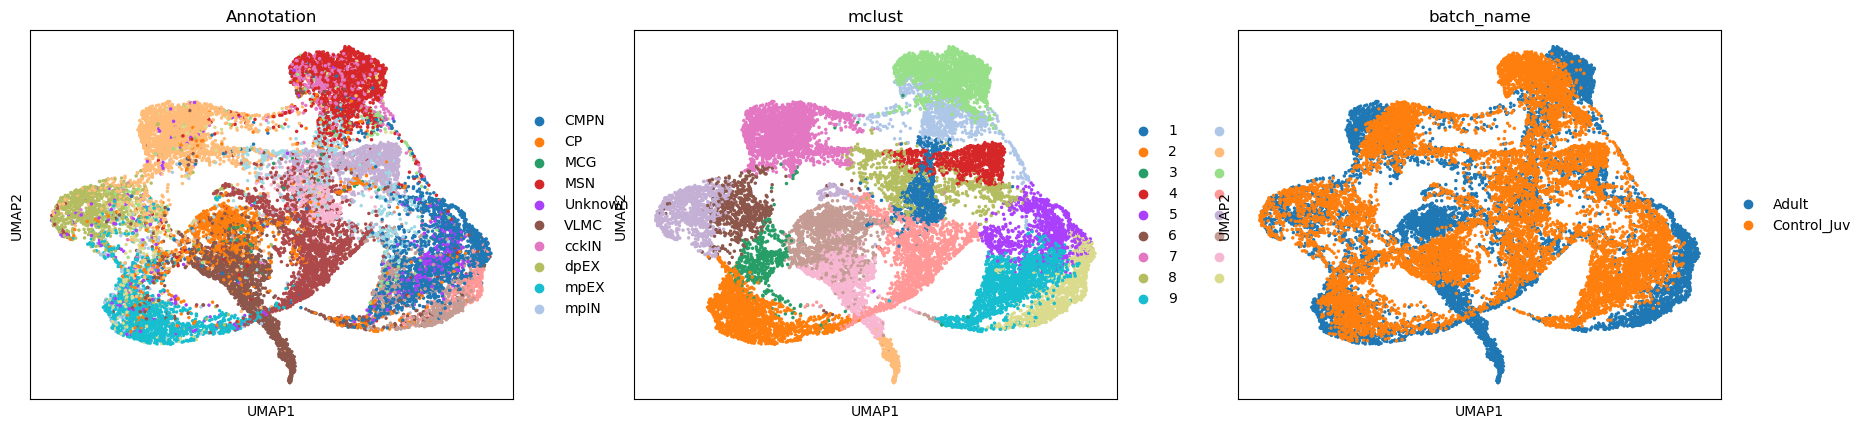

In [10]:
sc.pp.neighbors(adata, use_rep='latent', metric='cosine')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['Annotation', 'mclust', 'batch_name'], show=True, size=25, save=False)

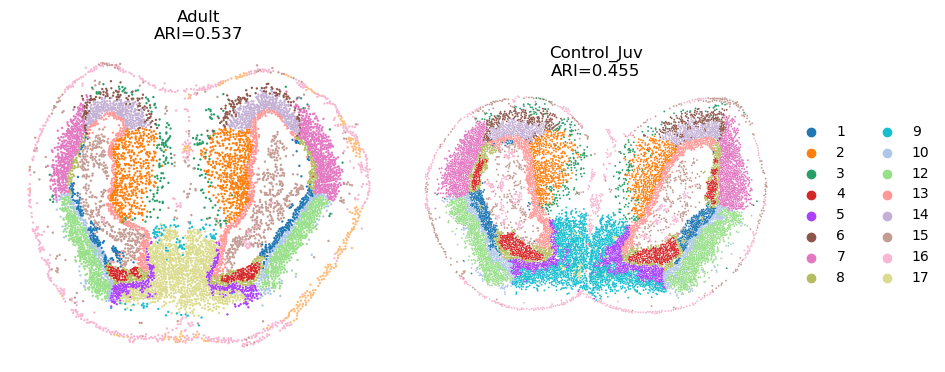

In [11]:
import matplotlib.pyplot as plt
sub_adata = adata[~pd.isnull(adata.obs['Annotation'])]
Batch_list = []
for section_id in proj_list:
    Batch_list.append(sub_adata[sub_adata.obs['batch_name'] == section_id])

spot_size = 35
title_size = 12
ARI_list = []
for bb in range(len(proj_list)):
    ARI_list.append(round(ari_score(Batch_list[bb].obs['Annotation'], Batch_list[bb].obs['mclust']), 3))

fig, ax = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
for idx in range(len(proj_list)):
    if idx == len(proj_list) - 1:  # 在最后一个子图显示图例
        _sc_ = sc.pl.spatial(Batch_list[idx], img_key=None, color=['mclust'], title=[''],
                          legend_loc='right margin', legend_fontsize=10, show=False, ax=ax[idx], frameon=False,
                          spot_size=spot_size)
    else:
        _sc_ = sc.pl.spatial(Batch_list[idx], img_key=None, color=['mclust'], title=[''],
                          legend_loc=None, legend_fontsize=12, show=False, ax=ax[idx], frameon=False,
                          spot_size=spot_size)
    _sc_[0].set_title(f"{proj_list[idx]}\nARI={ARI_list[idx]}", size=title_size)
# plt.savefig(f'clusters_AB.pdf', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

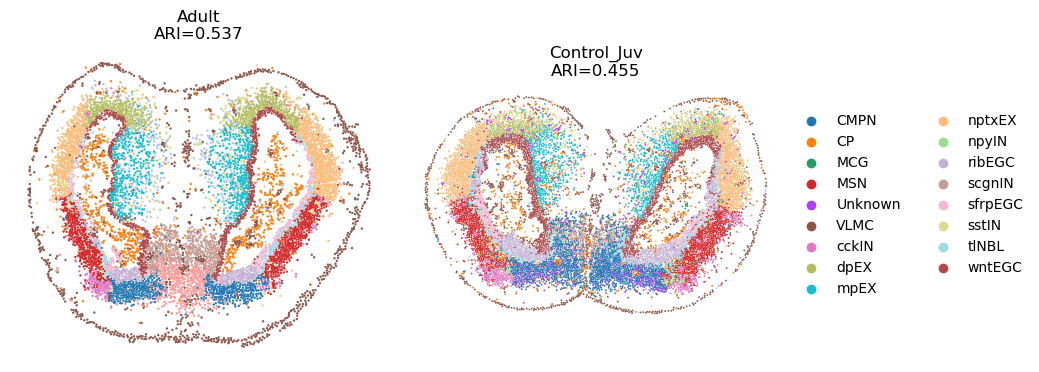

In [36]:
import matplotlib.pyplot as plt
sub_adata = adata[~pd.isnull(adata.obs['Annotation'])]
Batch_list = []
for section_id in proj_list:
    Batch_list.append(sub_adata[sub_adata.obs['batch_name'] == section_id])

spot_size = 35
title_size = 12
ARI_list = []
for bb in range(len(proj_list)):
    ARI_list.append(round(ari_score(Batch_list[bb].obs['Annotation'], Batch_list[bb].obs['mclust']), 3))

fig, ax = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
for idx in range(len(proj_list)):
    if idx == len(proj_list) - 1:  # 在最后一个子图显示图例
        _sc_ = sc.pl.spatial(Batch_list[idx], img_key=None, color=['Annotation'], title=[''],
                          legend_loc='right margin', legend_fontsize=10, show=False, ax=ax[idx], frameon=False,
                          spot_size=spot_size)
    else:
        _sc_ = sc.pl.spatial(Batch_list[idx], img_key=None, color=['Annotation'], title=[''],
                          legend_loc=None, legend_fontsize=12, show=False, ax=ax[idx], frameon=False,
                          spot_size=spot_size)
    _sc_[0].set_title(f"{proj_list[idx]}\nARI={ARI_list[idx]}", size=title_size)
plt.savefig(f'clusters_Annotation.pdf', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [7]:
sub_adata = adata[~pd.isnull(adata.obs['Annotation'])]
ARI = ari_score(sub_adata.obs['Annotation'], sub_adata.obs['mclust'])
print(f"total ARI:{ARI}")
for name in proj_list:
    sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
    ARI = ari_score(sub_adata_tmp.obs['Annotation'], sub_adata_tmp.obs['mclust'])
    print(f"{name} ARI:{ARI}")

total ARI:0.48246621381788113
Adult ARI:0.5370856628464878
Control_Juv ARI:0.4552659942686914


In [ ]:
adata = align_spatial_slices(adata, proj_list, n_sample=6000, random_seed=1234)

Using 6000 samples for alignment

Aligning slice Adult and Control_Juv
Found 1134 MNN pairs

Spatial alignment completed


In [17]:
with open('C:\\Code\\iSpa3D\\Config\\classifier_config.yaml', 'r', encoding='utf-8') as f:
    classifier_config = yaml.load(f.read(), Loader=yaml.FullLoader)
    
cluster_labels_original = adata.obs['mclust'].values.astype(int)
 
unique_labels = np.unique(cluster_labels_original)
label_mapping = {old: new for new, old in enumerate(sorted(unique_labels))}
cluster_labels_for_training = np.array([label_mapping[label] for label in cluster_labels_original])


classifier = iSpaNetClassifier(in_features=config['model']['latent_dim'], n_classes=len(unique_labels), config=classifier_config, device=device)
classifier.prepare_data(g3net_model=net, adata=adata, target_labels=cluster_labels_for_training)
classifier.train(epochs=classifier.max_epochs, verbose=True, early_stop_patience=50)

Epoch [ 10/300] Train Loss: 0.6238, Train Acc: 0.7775 | Val Loss: 0.3252, Val Acc: 0.8987
Epoch [ 20/300] Train Loss: 0.5784, Train Acc: 0.7939 | Val Loss: 0.3489, Val Acc: 0.8857
Epoch [ 30/300] Train Loss: 0.5677, Train Acc: 0.8003 | Val Loss: 0.3153, Val Acc: 0.8937
Epoch [ 40/300] Train Loss: 0.5732, Train Acc: 0.7994 | Val Loss: 0.3225, Val Acc: 0.8837
Epoch [ 50/300] Train Loss: 0.5556, Train Acc: 0.8060 | Val Loss: 0.3428, Val Acc: 0.8892
Epoch [ 60/300] Train Loss: 0.5398, Train Acc: 0.8097 | Val Loss: 0.3399, Val Acc: 0.8952
Epoch [ 70/300] Train Loss: 0.5560, Train Acc: 0.8024 | Val Loss: 0.3105, Val Acc: 0.8912
Epoch [ 80/300] Train Loss: 0.5531, Train Acc: 0.8036 | Val Loss: 0.3086, Val Acc: 0.8962
Epoch [ 90/300] Train Loss: 0.5579, Train Acc: 0.8025 | Val Loss: 0.3281, Val Acc: 0.8902
Epoch [100/300] Train Loss: 0.5413, Train Acc: 0.8060 | Val Loss: 0.3361, Val Acc: 0.8907
Epoch [110/300] Train Loss: 0.5431, Train Acc: 0.8071 | Val Loss: 0.3465, Val Acc: 0.8847

Early sto

In [ ]:
import importlib, iSp3D.Attribution as attr_mod
importlib.reload(attr_mod)

res_df = compute_and_summary_by_cluster(
    net=net,
    cluster_key='mclust',
    classifier=classifier,
    top_k=100,
    pca=pca, 
    target_clusters=None,
)

Computing attributions for 17 clusters...


Cluster attribution:   0%|          | 0/17 [00:00<?, ?it/s]

Cluster 1: neighbors = ['10', '12', '8']


Cluster attribution:   6%|▌         | 1/17 [01:18<20:49, 78.09s/it]

Cluster 10: neighbors = ['5', '12', '8', '1']


Cluster attribution:  12%|█▏        | 2/17 [02:45<20:57, 83.84s/it]

Cluster 11: neighbors = ['16']


Cluster attribution:  18%|█▊        | 3/17 [03:17<13:59, 60.00s/it]

Cluster 12: neighbors = ['10', '1']


Cluster attribution:  24%|██▎       | 4/17 [04:09<12:16, 56.67s/it]

Cluster 13: neighbors = ['5', '8', '15', '2', '14']


Cluster attribution:  29%|██▉       | 5/17 [05:33<13:20, 66.68s/it]

Cluster 14: neighbors = ['13', '6']


Cluster attribution:  35%|███▌      | 6/17 [06:27<11:25, 62.31s/it]

Cluster 15: neighbors = ['16', '13', '1']


Cluster attribution:  41%|████      | 7/17 [07:43<11:07, 66.75s/it]

Cluster 16: neighbors = ['15']


Cluster attribution:  47%|████▋     | 8/17 [08:10<08:07, 54.21s/it]

Cluster 17: neighbors = ['9']


Cluster attribution:  53%|█████▎    | 9/17 [08:38<06:06, 45.84s/it]

Cluster 2: neighbors = ['13', '3', '14']


Cluster attribution:  59%|█████▉    | 10/17 [09:55<06:29, 55.59s/it]

Cluster 3: neighbors = ['6']


Cluster attribution:  65%|██████▍   | 11/17 [10:23<04:42, 47.08s/it]

Cluster 4: neighbors = ['5', '8']


Cluster attribution:  71%|███████   | 12/17 [11:17<04:05, 49.12s/it]

Cluster 5: neighbors = ['10', '8', '4', '13']


Cluster attribution:  76%|███████▋  | 13/17 [12:33<03:49, 57.50s/it]

Cluster 6: neighbors = ['7', '14', '3']


Cluster attribution:  82%|████████▏ | 14/17 [13:48<03:08, 62.75s/it]

Cluster 7: neighbors = ['10', '8', '6']


Cluster attribution:  88%|████████▊ | 15/17 [15:06<02:14, 67.23s/it]

Cluster 8: neighbors = ['5', '10', '4', '13', '1', '7']


Cluster attribution:  94%|█████████▍| 16/17 [16:21<01:09, 69.56s/it]

Cluster 9: neighbors = ['17']


Cluster attribution: 100%|██████████| 17/17 [16:49<00:00, 59.38s/it]


In [13]:
# 解包归因结果
final_dfs, top_dict, per_method_dfs = res_df
for method, cluster_map in per_method_dfs.items():
    print(f"\n{'=' * 80}")
    print(f"归因方法: {method}")
    print(f"{'=' * 80}")
    
    # 直接遍历聚类结果
    for cluster_label in sorted(cluster_map.keys()):
        df = cluster_map[cluster_label]
        top20 = df.sort_values('diff', ascending=False).head(20)
        
        print(f"\n【Cluster {cluster_label}】 - Top 20 基因 (按 diff 排序):")
        print(f"{'Gene':<15} {'Mean_In':>10} {'Mean_Other':>12} {'Diff':>10}")
        print("-" * 50)
        
        for gene in top20.index:
            mean_in = top20.loc[gene, 'mean_in']
            mean_other = top20.loc[gene, 'mean_other']
            diff = top20.loc[gene, 'diff']
            gene_str = str(gene)
            print(f"{gene_str:<15} {mean_in:>10.4f} {mean_other:>12.4f} {diff:>10.4f}")
        print()


归因方法: ig

【Cluster 1】 - Top 20 基因 (按 diff 排序):
Gene               Mean_In   Mean_Other       Diff
--------------------------------------------------
ZIC1 | AMEX60DD001970    -0.0137      -0.0682     0.0546
ZIC2 | AMEX60DD048179    -0.0125      -0.0635     0.0509
PRDM16 | AMEX60DD051365    -0.0081      -0.0544     0.0463
ZIC3 | AMEX60DD037412    -0.0030      -0.0455     0.0425
VAX2 | AMEX60DD046262     0.0061      -0.0336     0.0397
SCGN | AMEX60DD038981    -0.0075      -0.0433     0.0358
AMEX60DDU001001926     0.0436       0.0119     0.0317
NXPH1 | AMEX60DD022514     0.0021      -0.0290     0.0312
CCER2[nr]|CHGA[hs] | AMEX60DD024290     0.0794       0.0501     0.0294
OTX2 | AMEX60DD011133     0.0003      -0.0290     0.0293
NFIB | AMEX60DD043470     0.0363       0.0071     0.0292
DR999_PMT12449[nr]|SLC6A1[hs] | AMEX60DD023994     0.0548       0.0274     0.0275
AMEX60DD003686     -0.0015      -0.0289     0.0274
SHISA6 | AMEX60DD030578     0.0219      -0.0053     0.0272
GFRA4[nr]|GFRA1[h

In [14]:
for cluster_label in sorted(final_dfs.keys()):
    obj = final_dfs[cluster_label]
    
    if isinstance(obj, pd.DataFrame):
        sort_col = 'final_score' if 'final_score' in obj.columns else ('diff' if 'diff' in obj.columns else None)
        if sort_col:
            genes = obj.sort_values(sort_col, ascending=False).head(20).index.tolist()
        else:
            genes = obj.index[:20].tolist()
    else:
        genes = list(obj)[:20]
    
    print(f"Cluster {cluster_label}: {genes}")


Cluster 1: ['ZIC1 | AMEX60DD001970', 'ZIC2 | AMEX60DD048179', 'PRDM16 | AMEX60DD051365', 'VAX2 | AMEX60DD046262', 'ZIC3 | AMEX60DD037412', 'SCGN | AMEX60DD038981', 'NFIB | AMEX60DD043470', 'AMEX60DDU001001926', 'AMEX60DD003686', 'OTX2 | AMEX60DD011133', 'SHISA6 | AMEX60DD030578', 'NXPH1 | AMEX60DD022514', 'TENM2 | AMEX60DD030344', 'SLIT2 | AMEX60DD045792', 'CUNH3ORF80[nr]|C3ORF80[hs] | AMEX60DD001813', 'GFRA4[nr]|GFRA1[hs] | AMEX60DD046226', 'CNR1 | AMEX60DD033978', 'GPR17 | AMEX60DD002656', 'LOC107743981[nr]|SIX6[hs] | AMEX60DD011857', 'LMO3 | AMEX60DD006666']
Cluster 10: ['UNC5D | AMEX60DD002483', 'BCAM | AMEX60DD018132', 'UACA | AMEX60DD004251', 'TAGLN | AMEX60DD053922', 'CCND1 | AMEX60DD005040', 'SLC29A4 | AMEX60DD025690', 'GFRA4[nr]|GFRA1[hs] | AMEX60DD046226', 'FBN3[nr]|FBN2[hs] | AMEX60DD014606', 'GLRX | AMEX60DD042610', 'GPX8 | AMEX60DD042105', 'AMEX60DD001671', 'AMEX60DD005413', 'ANGPTL7 | AMEX60DD051136', 'PXN | AMEX60DD000525', 'TTC6 | AMEX60DD012264', 'PCP4 | AMEX60DD047161

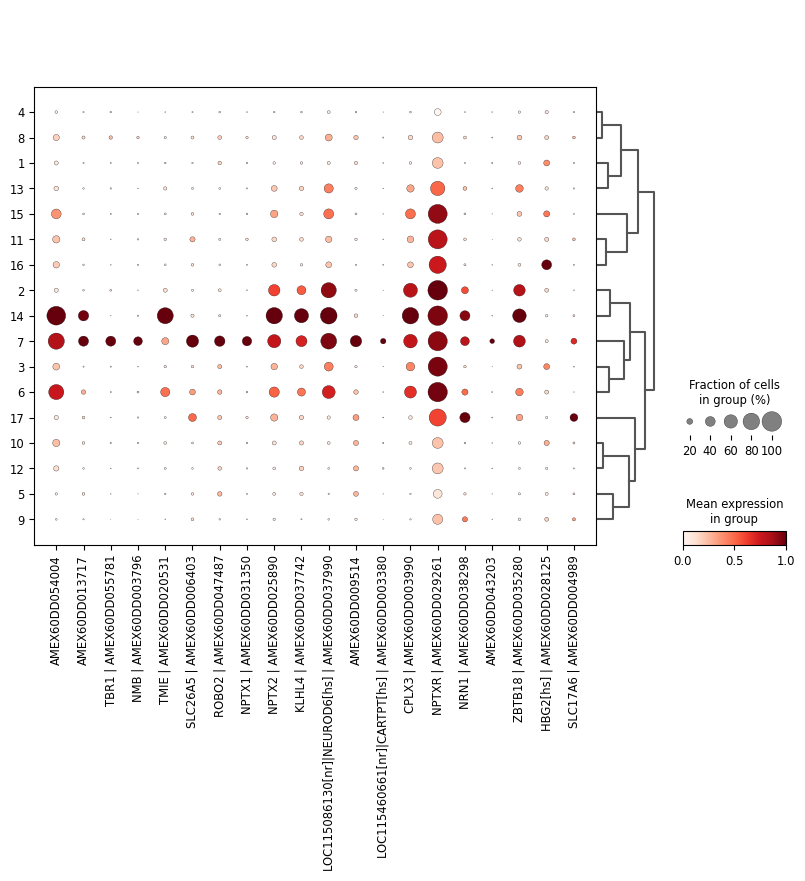

In [31]:
adata = sc.read(r"C:\Code\Answer\AJ\Ours.h5ad")
adata.obs['re_mclust'] = adata.obs['mclust'].astype(str)
dg = ['AMEX60DD054004', 'AMEX60DD013717', 'TBR1 | AMEX60DD055781', 'NMB | AMEX60DD003796', 'TMIE | AMEX60DD020531', 'SLC26A5 | AMEX60DD006403', 'ROBO2 | AMEX60DD047487', 'NPTX1 | AMEX60DD031350', 'NPTX2 | AMEX60DD025890', 'KLHL4 | AMEX60DD037742', 'LOC115086130[nr]|NEUROD6[hs] | AMEX60DD037990', 'AMEX60DD009514', 'LOC115460661[nr]|CARTPT[hs] | AMEX60DD003380', 'CPLX3 | AMEX60DD003990', 'NPTXR | AMEX60DD029261', 'NRN1 | AMEX60DD038298', 'AMEX60DD043203', 'ZBTB18 | AMEX60DD035280', 'HBG2[hs] | AMEX60DD028125', 'SLC17A6 | AMEX60DD004989']

sc.pl.dotplot(adata, dg, groupby='re_mclust', dendrogram=True, swap_axes=False, standard_scale='var')

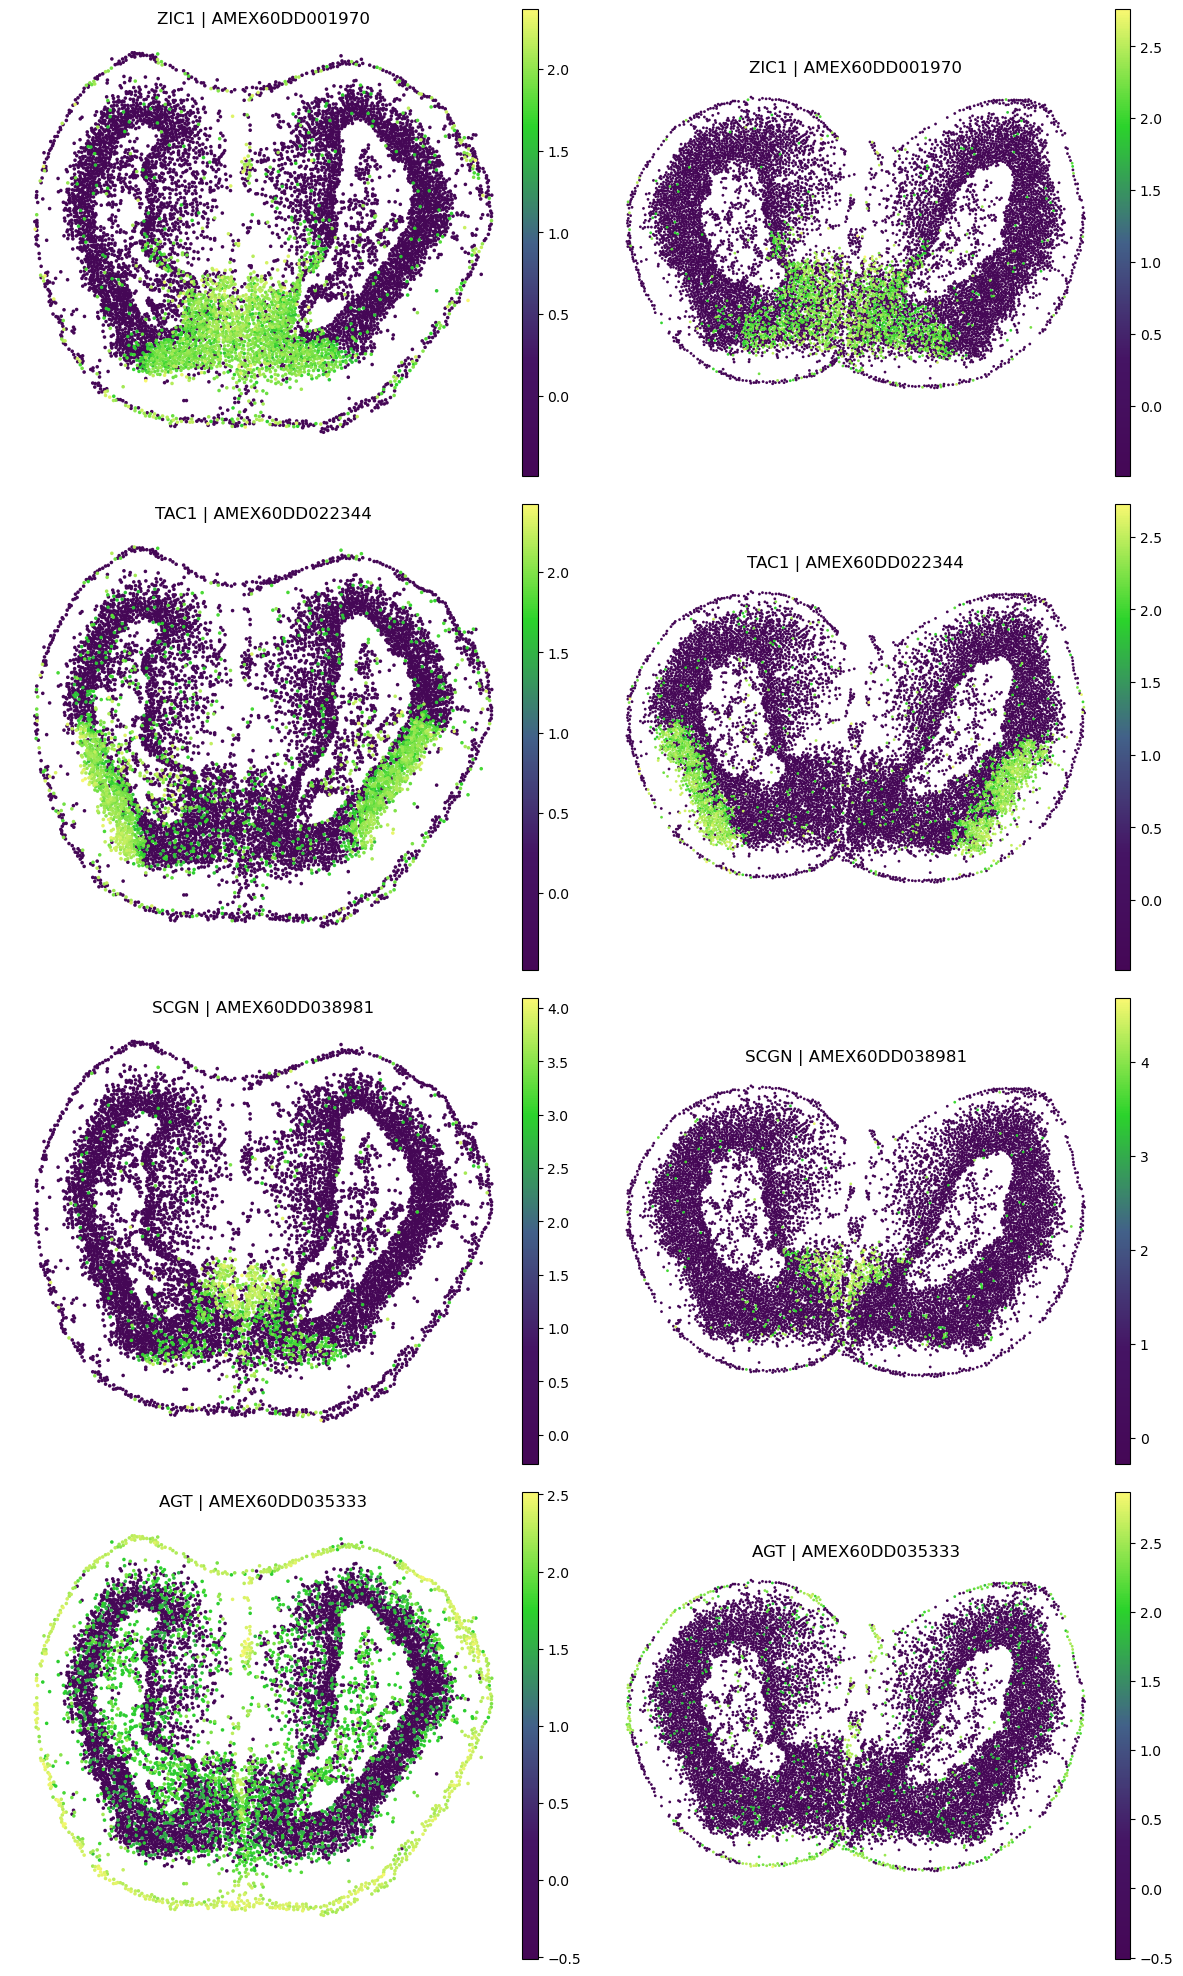

In [44]:
import matplotlib.colors as clr

selected_genes = ['ZIC1 | AMEX60DD001970', 'TAC1 | AMEX60DD022344','SCGN | AMEX60DD038981','AGT | AMEX60DD035333',]
fig, axes = plt.subplots(len(selected_genes), len(proj_list), figsize=(12, len(selected_genes) * 5))
color_map = clr.LinearSegmentedColormap.from_list('pink_green',['#450756', '#451464', '#426189', '#2BD32B', '#F9F871'], N=256)
# 对每个基因进行循环绘制
for i, gene in enumerate(selected_genes):
    for j, proj in enumerate(proj_list):
        # 提取对应平台的数据
        adata_proj = adata[adata.obs['batch_name'] == proj]  # 假设adata.obs['platform']表示平台信息

        # 使用空间图绘制
        sc.pl.spatial(
            adata_proj,
            color=gene,
            cmap=color_map,
            spot_size=40,  # 可调整点大小
            frameon=False,
            title=gene,
            legend_loc=None,
            show=False,
            ax=axes[i, j]  # 将图像绘制到对应的子图中
        )

# 调整布局，避免子图重叠
plt.tight_layout()
plt.savefig('Original_expression.pdf', bbox_inches='tight')
plt.show()

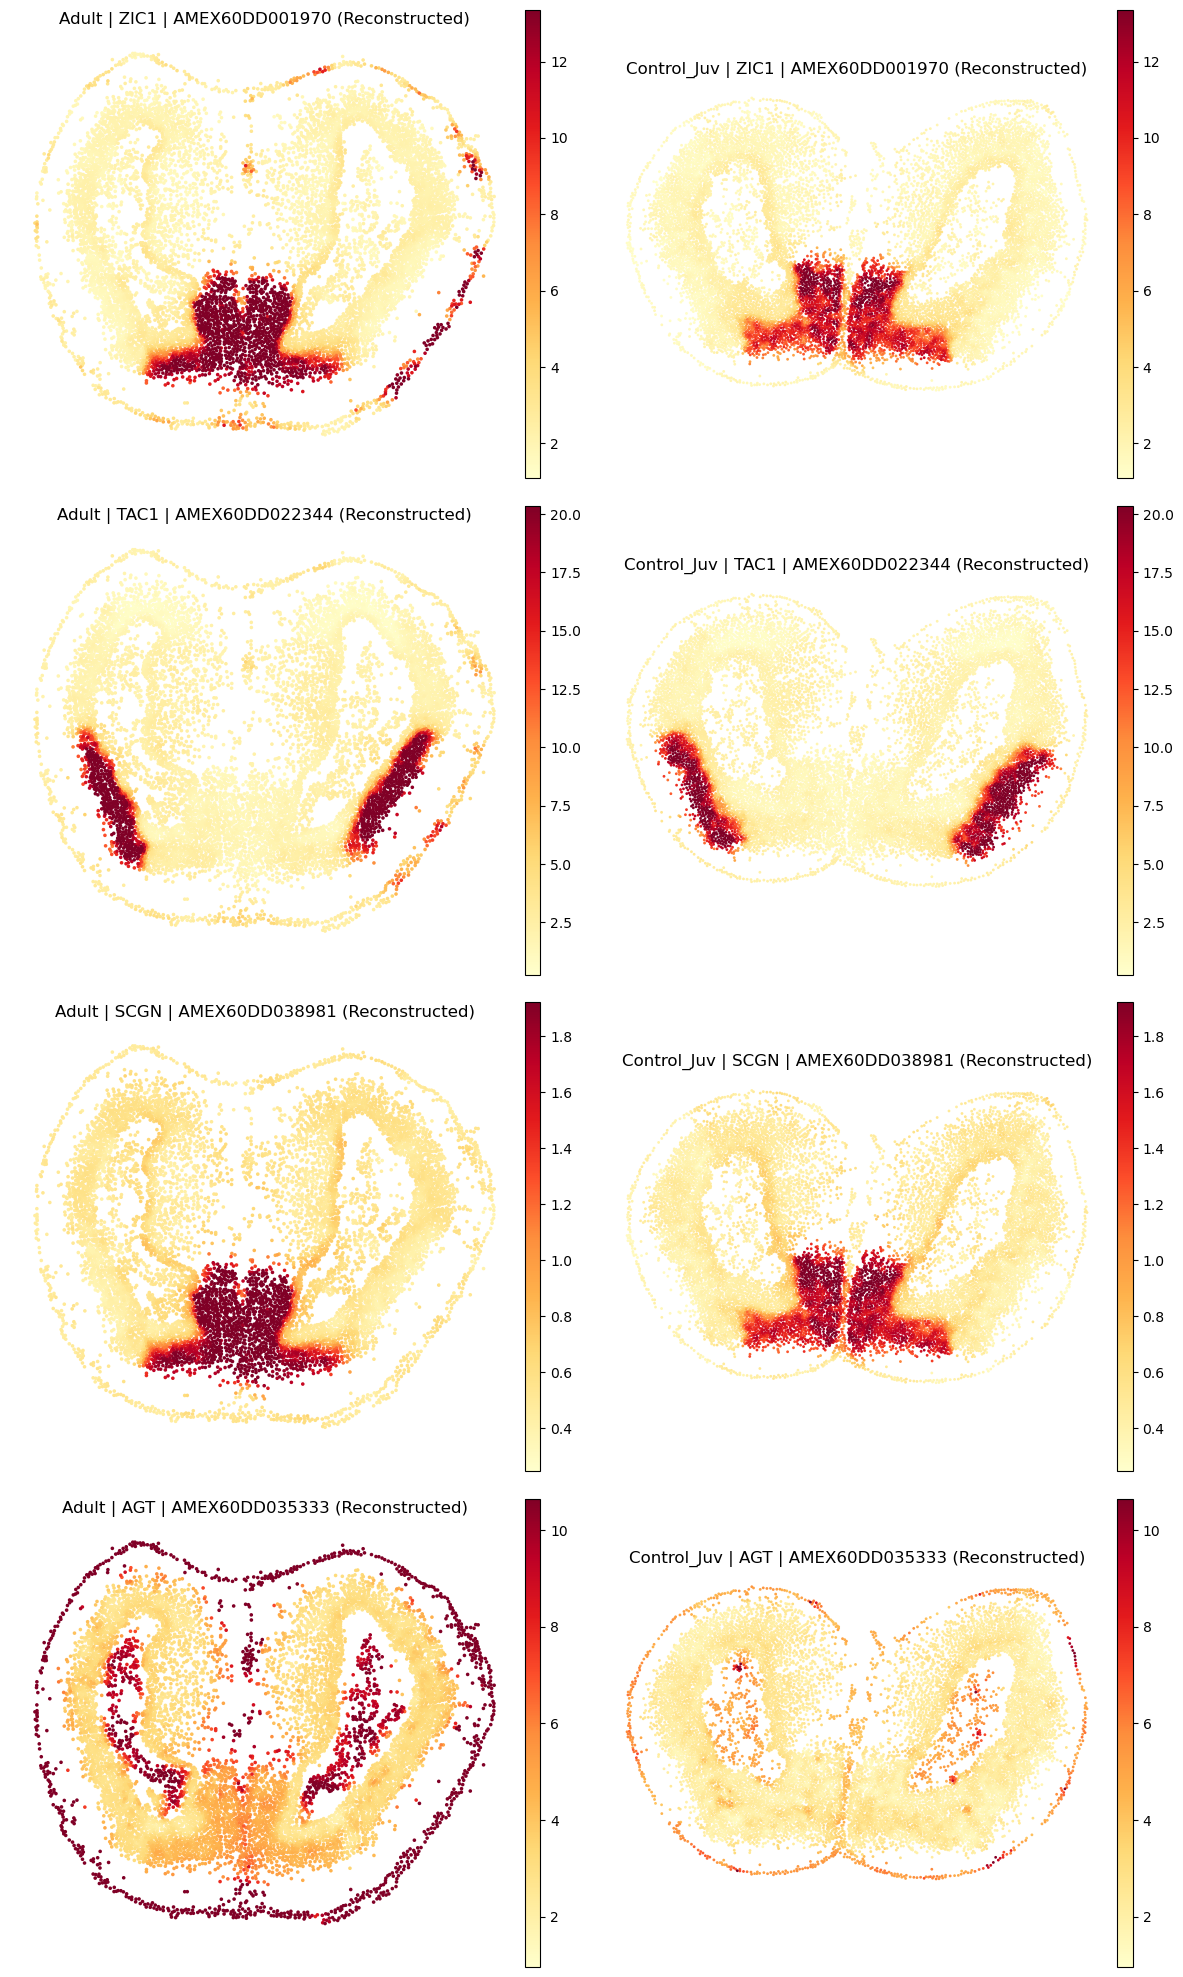

In [49]:
import matplotlib.colors as clr
# Use the colormap from the provided image: blue to red gradient
plasma_soft = clr.LinearSegmentedColormap.from_list(
    'ylorrd_gradient',
    ['#ffffcc', '#ffeda0', '#fed976', '#feb24c', '#fd8d3c',
     '#fc4e2a', '#e31a1c', '#bd0026', '#800026'],
    N=256
)

recon_df = pd.DataFrame(
    adata.obsm['X_reconstructed'],
    index=adata.obs_names,
    columns=adata.var_names
)

fig, axes = plt.subplots(len(selected_genes), len(proj_list),
                         figsize=(12, len(selected_genes) * 5))

for i, gene in enumerate(selected_genes):
    if gene not in recon_df.columns:
        print(f"Warning: Gene '{gene}' not found in reconstructed data, skipping.")
        continue

    vmin = recon_df[gene].min()
    # Use 99th percentile for adaptive upper limit to handle outliers
    vmax = np.percentile(recon_df[gene].values, 95)

    for j, proj in enumerate(proj_list):
        adata_proj = adata[adata.obs['batch_name'] == proj].copy()

        col = f'recon_{gene}'
        adata_proj.obs[col] = recon_df.loc[adata_proj.obs_names, gene].values

        sc.pl.spatial(
            adata_proj,
            color=col,
            cmap=plasma_soft,
            vmin=vmin, vmax=vmax,
            colorbar_loc='right',
            spot_size=40,
            frameon=False,
            title=f'{proj} | {gene} (Reconstructed)',
            legend_loc=None,
            show=False,
            ax=axes[i, j]
        )

plt.tight_layout()
plt.savefig('reconstructed_gene_expression.pdf', bbox_inches='tight')
plt.show()

Visualizing gene: TBR1 | AMEX60DD055781


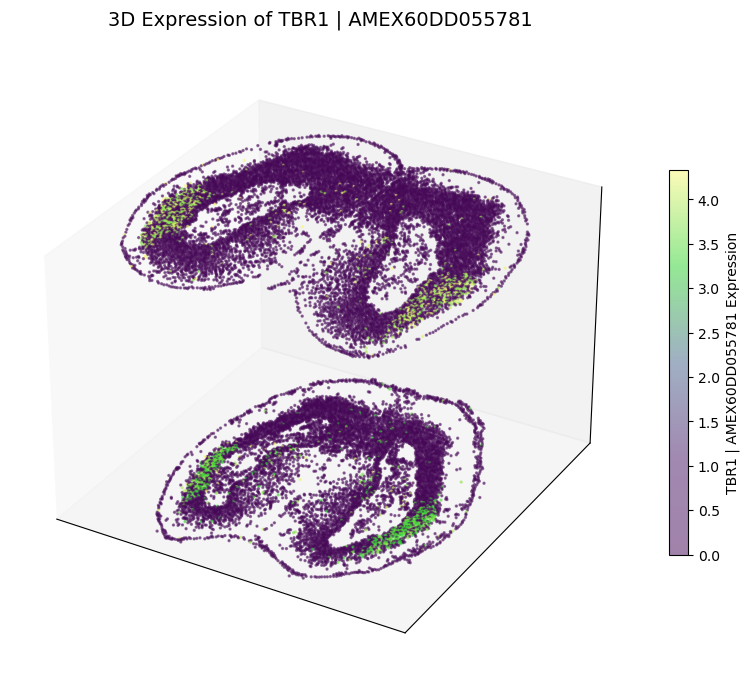

✓ Saved: gene_TBR1__AMEX60DD055781_3d.pdf


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as clr
proj_list = ['Adult', 'Control_Juv']
gene_list = ['TBR1 | AMEX60DD055781']

z_scale = 0.2  
n_slices = len(proj_list)
adata_st_list = [adata[adata.obs['batch_name'] == proj_name].copy() for proj_name in proj_list]

for i_slice in range(n_slices):
    if 'spatial_3d' not in adata_st_list[i_slice].obsm:
        loc_tmp = np.ones((adata_st_list[i_slice].shape[0], 3)) * i_slice
        loc_tmp[:, :2] = adata_st_list[i_slice].obsm['spatial_regi']
        adata_st_list[i_slice].obsm['spatial_3d'] = loc_tmp
    adata_st_list[i_slice].obsm['spatial_3d'][:, 2] *= z_scale

reds_cmap = clr.LinearSegmentedColormap.from_list(
    'pink_green',
    ['#450756', '#451464', '#426189', '#2BD32B', '#F9F871'],
    N=256
)

for gene_name in gene_list:
    if gene_name not in adata.var_names:
        print(f"Warning: Gene '{gene_name}' not found in adata, skipping...")
        continue

    print(f"Visualizing gene: {gene_name}")

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    all_coords = np.vstack([ad.obsm['spatial_3d'] for ad in adata_st_list])
    x_min, x_max = all_coords[:, 0].min(), all_coords[:, 0].max()
    y_min, y_max = all_coords[:, 1].min(), all_coords[:, 1].max()
    z_min, z_max = all_coords[:, 2].min(), all_coords[:, 2].max()

    x_margin = (x_max - x_min) * 0.005
    y_margin = (y_max - y_min) * 0.005
    z_margin = (z_max - z_min) * 0.05 if z_max > z_min else 0.05

    ax.set_xlim(x_min - x_margin, x_max + x_margin)
    ax.set_ylim(y_min - y_margin, y_max + y_margin)
    ax.set_zlim(z_min - z_margin, z_max + z_margin)

    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    all_expr = []
    for i_slice in range(n_slices):
        expr = np.array(adata_st_list[i_slice][:, gene_name].X.toarray()).reshape(-1)
        all_expr.extend(expr)
    all_expr = np.array(all_expr)
    vmin = 0
    vmax = np.percentile(all_expr[all_expr > 0], 95) if np.any(all_expr > 0) else 1

    for i_slice in range(n_slices):
        gene_expr = np.array(adata_st_list[i_slice][:, gene_name].X.toarray()).reshape(-1)
        ax.scatter(
            adata_st_list[i_slice].obsm['spatial_3d'][:, 0],
            adata_st_list[i_slice].obsm['spatial_3d'][:, 1],
            adata_st_list[i_slice].obsm['spatial_3d'][:, 2],
            rasterized=True,
            s=2,
            c=gene_expr,
            alpha=0.5,
            cmap=reds_cmap,
            vmax=vmax,
            vmin=vmin,
        )

    plt.colorbar(ax.collections[-1], ax=ax, shrink=0.5, label=f'{gene_name} Expression')
    ax.set_title(f'3D Expression of {gene_name}', fontsize=14, pad=20)

    safe_gene = gene_name.replace(' ', '_').replace('|', '').replace('/', '_').replace('\\', '_')
    plt.savefig(f'gene_{safe_gene}_3d.pdf', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✓ Saved: gene_{safe_gene}_3d.pdf")

Visualizing reconstructed gene: TBR1 | AMEX60DD055781


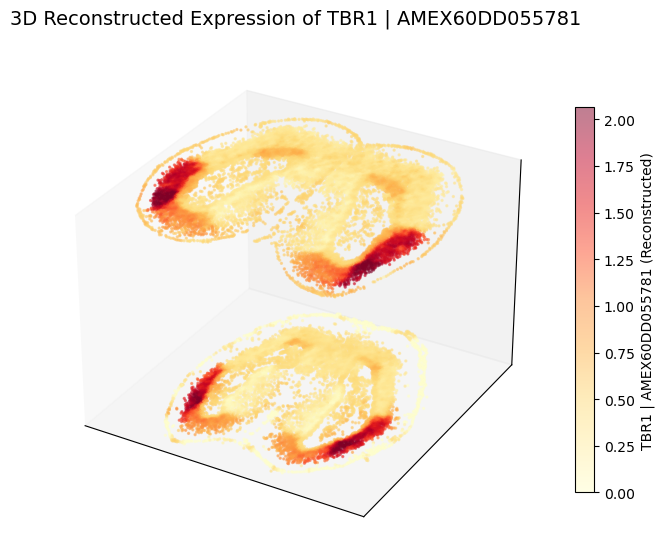

✓ Saved: gene_TBR1__AMEX60DD055781_3d_recon.pdf


In [ ]:
# 3D reconstructed gene visualization (two slices stacked, compressed z-gap, 95th pct cap, custom reds colormap, using X_reconstructed)
import matplotlib.colors as clr

gene_list = ['ZIC2 | AMEX60DD048179', 'TAC1 | AMEX60DD022344', 'SCGN | AMEX60DD038981', 'AGT | AMEX60DD035333']
z_scale = 0.2  # 压缩切片间距
n_slices = len(proj_list)

# 准备重构表达矩阵
recon_df = pd.DataFrame(
    adata.obsm['X_reconstructed'],
    index=adata.obs_names,
    columns=adata.var_names
)

# 切片列表
adata_st_list = [adata[adata.obs['batch_name'] == proj_name].copy() for proj_name in proj_list]

# 确保 spatial_3d 并压缩 z
for i_slice in range(n_slices):
    if 'spatial_3d' not in adata_st_list[i_slice].obsm:
        loc_tmp = np.ones((adata_st_list[i_slice].shape[0], 3)) * i_slice
        loc_tmp[:, :2] = adata_st_list[i_slice].obsm['spatial_regi']
        adata_st_list[i_slice].obsm['spatial_3d'] = loc_tmp
    adata_st_list[i_slice].obsm['spatial_3d'][:, 2] *= z_scale

reds_cmap = clr.LinearSegmentedColormap.from_list(
    'reds_grad',
    ['#ffffcc', '#ffeda0', '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026', '#800026'],
    N=256
)

for gene_name in gene_list:
    if gene_name not in recon_df.columns:
        print(f"Warning: Gene '{gene_name}' not found in reconstructed data, skipping...")
        continue

    print(f"Visualizing reconstructed gene: {gene_name}")

    fig = plt.figure(figsize=(8, 10))
    ax = fig.add_subplot(111, projection='3d')

    all_coords = np.vstack([ad.obsm['spatial_3d'] for ad in adata_st_list])
    x_min, x_max = all_coords[:, 0].min(), all_coords[:, 0].max()
    y_min, y_max = all_coords[:, 1].min(), all_coords[:, 1].max()
    z_min, z_max = all_coords[:, 2].min(), all_coords[:, 2].max()

    x_margin = (x_max - x_min) * 0.005
    y_margin = (y_max - y_min) * 0.005
    z_margin = (z_max - z_min) * 0.05 if z_max > z_min else 0.05

    ax.set_xlim(x_min - x_margin, x_max + x_margin)
    ax.set_ylim(y_min - y_margin, y_max + y_margin)
    ax.set_zlim(z_min - z_margin, z_max + z_margin)

    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    # 全部切片的重构表达用于 vmin/vmax
    all_expr = []
    for i_slice in range(n_slices):
        expr = recon_df.loc[adata_st_list[i_slice].obs_names, gene_name].values
        all_expr.extend(expr)
    all_expr = np.array(all_expr)
    vmin = 0
    vmax = np.percentile(all_expr[all_expr > 0], 95) if np.any(all_expr > 0) else 1

    # 绘制每个切片
    for i_slice in range(n_slices):
        gene_expr = recon_df.loc[adata_st_list[i_slice].obs_names, gene_name].values
        ax.scatter(
            adata_st_list[i_slice].obsm['spatial_3d'][:, 0],
            adata_st_list[i_slice].obsm['spatial_3d'][:, 1],
            adata_st_list[i_slice].obsm['spatial_3d'][:, 2],
            rasterized=True,
            s=2,
            c=gene_expr,
            alpha=0.5,
            cmap=reds_cmap,
            vmax=vmax,
            vmin=vmin,
        )

    plt.colorbar(ax.collections[-1], ax=ax, shrink=0.5, label=f'{gene_name} (Reconstructed)')
    ax.set_title(f'3D Reconstructed Expression of {gene_name}', fontsize=14, pad=20)

    safe_gene = gene_name.replace(' ', '_').replace('|', '').replace('/', '_').replace('\\', '_')
    plt.savefig(f'gene_{safe_gene}_3d_recon.pdf', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✓ Saved: gene_{safe_gene}_3d_recon.pdf")